# UberEats店舗データ分析(武蔵中原近辺)

In [1]:
import pandas as pd
import datetime
import seaborn as sns
from pyproj import Geod
import japanize_matplotlib

In [2]:
FILE_PATH = './../data/shop_master.csv'
master = pd.read_csv(FILE_PATH, index_col='id')

In [3]:
len(master)

308

In [4]:
master.head(3)

,address,close_hour,latitude,longitude,name,open_hour,point,postal_code,reviews,url
id,,,,,,,,,,
nWVRj3lxR-GgHArpgXaG-A,神奈川県横浜市港北区日吉本町1-16-20 Kanagawa,21:00,35.553888,139.644080,キッチン オリジン 日吉中央通り Kitchen Origin Hiyoshichuodori,10:00,4.2,223-0062,26.0,https://www.ubereats.com/ja-JP/yokohama/food-d...
NwDRwsDqS7-xf7e3844hsA,神奈川県川崎市高津区溝口２丁目３－１３,22:00,35.599877,139.609638,バーミヤン 溝の口店 Bamiyan Mizonokuchi,10:30,4.5,213-0001,102.0,https://www.ubereats.com/ja-JP/yokohama/food-d...
kRn0KFEVR5CKiFlocLwC_g,神奈川県 川崎市 高津区 千年 665 Kawasaki,21:00,35.577274,139.628568,とんかつ後藤 Tonkatsu Goto,17:00,NaN,213-0022,NaN,https://www.ubereats.com/ja-JP/yokohama/food-d...


In [5]:
df = master.assign(
    shop_position_id = master.apply(lambda x: str(x.latitude) + "-" + str(x.longitude), axis=1)).drop(["address", "url"], axis=1)

In [6]:
df.head(3)

,close_hour,latitude,longitude,name,open_hour,point,postal_code,reviews,shop_position_id
id,,,,,,,,,
nWVRj3lxR-GgHArpgXaG-A,21:00,35.553888,139.644080,キッチン オリジン 日吉中央通り Kitchen Origin Hiyoshichuodori,10:00,4.2,223-0062,26.0,35.55388770000001-139.6440797
NwDRwsDqS7-xf7e3844hsA,22:00,35.599877,139.609638,バーミヤン 溝の口店 Bamiyan Mizonokuchi,10:30,4.5,213-0001,102.0,35.5998771-139.6096381
kRn0KFEVR5CKiFlocLwC_g,21:00,35.577274,139.628568,とんかつ後藤 Tonkatsu Goto,17:00,NaN,213-0022,NaN,35.5772743-139.6285682


## 最寄り駅ごとにお店を分類する

武蔵中原、武蔵新城、武蔵小杉、武蔵溝ノ口、その他の分類でお店を分類する。半径1km県内を最寄りと定義する。

In [7]:
kosugi_lat, kosugi_lng = 35.5766335,139.6572773 # 武蔵小杉駅
nakahara_lat, nakahara_lng = 35.5807143,139.6399183 # 武蔵中原駅
shinjo_lat, shinjo_lng = 35.58718,139.6276537 # 武蔵新城
mizonokuchi_lat, mizonokuchi_lng = 35.5991055,139.6087969 # 武蔵溝ノ口駅

stations = [
    ["武蔵小杉", [kosugi_lat, kosugi_lng]],
    ["武蔵中原", [nakahara_lat, nakahara_lng]],
    ["武蔵新城", [shinjo_lat, shinjo_lng]],
    ["武蔵溝ノ口", [mizonokuchi_lat, mizonokuchi_lng]]
]

In [8]:
def is_near_station(station_lat, station_lng, shop_lat, shop_lng):
    grs80 = Geod(ellps='GRS80')  # GRS80楕円体
 
    _, _, distance = grs80.inv(station_lng, station_lat, shop_lng, shop_lat)

    return distance <= 1000

def get_near_station_name(station, shop_lat, shop_lng, v):
    station_name = station[0]
    station_position = station[1]
    
    if is_near_station(station_position[0], station_position[1], shop_lat, shop_lng):
        return station_name
    else:
        if v != "その他":
            return v
        else:
            return "その他"

In [9]:
df["near_station"] = "その他"

for station in stations:
    df["near_station"] = df.apply(lambda x: get_near_station_name(station, x.latitude, x.longitude, x.near_station), axis=1)

In [10]:
output = pd.DataFrame(df.groupby("near_station").count()["name"])
output.index.name = "最寄り駅"
output = output.rename(columns = {"name": "店舗数"})

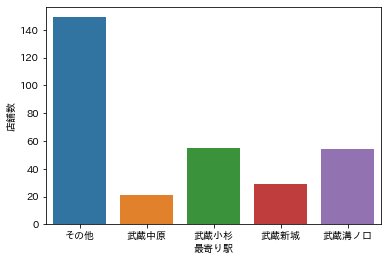

In [11]:
sns.barplot(x="最寄り駅", y="店舗数", data=output.reset_index())

## 店舗数の集計

In [12]:
output

,店舗数
最寄り駅,
その他,149
武蔵中原,21
武蔵小杉,55
武蔵新城,29
武蔵溝ノ口,54


## レビュー数と評価の集計

In [13]:
output2 = pd.DataFrame(df.groupby("near_station").sum()[["reviews", "point"]])

In [14]:
output2

,reviews,point
near_station,,
その他,14065.0,523.2
武蔵中原,1931.0,76.2
武蔵小杉,5977.0,201.4
武蔵新城,3351.0,76.3
武蔵溝ノ口,6281.0,182.4


小杉の方が溝の口よりも、レビュー数が少ないにも関わらず評価ポイントの合計が高いということは、溝の口よりも小杉のほうがよい店が多いということ？

## チェーン店の調査

In [15]:
def is_chain(x):
    if "店" in x:
        return True
    else:
        return False

df["is_chain"] = df["name"].apply(is_chain)

In [16]:
pd.crosstab(df['near_station'], df['is_chain'])

is_chain,False,True
near_station,,
その他,69,80
武蔵中原,12,9
武蔵小杉,27,28
武蔵新城,15,14
武蔵溝ノ口,22,32


In [17]:
print("武蔵小杉: {}%".format(round((25/48)*100)))
print("武蔵溝ノ口: {}%".format(round((32/53)*100)))

武蔵小杉: 52%
武蔵溝ノ口: 60%
